# Investment Simulation
The goal of this notebook is to estimate finances in retirement based on inputs
such as contribution percentages to various account types, investment growth,
required minimum distributions, etc.

The inputs are listed first, and projections are performed at the end. Review each
section and update as needed as.

In [1]:
from life_model.simulation import Simulation

simulation = Simulation(
    end_year = 2092
)

## People
This section captures information about the people being studied

In [2]:
from life_model.family import Family
from life_model.person import Person, Spending

family = Family(simulation)

john = Person(
    family = family,
    name = 'John',
    age = 44,
    retirement_age = 60,
    spending = Spending(
        base = 12000,
        yearly_increase = 5
    )
)

jane = Person(
    family = family,
    name = 'Jane',
    age = 45,
    retirement_age = 60,
    spending = Spending(
        base = 12000,
        yearly_increase = 5
    )
)

family

## Bank Accounts
Bank accounts associated with each person. These earn a small amount of interest, which may be compounded at different rates, however the rates are much lower than other types of accounts.

In [3]:
from life_model.account.bank import BankAccount

BankAccount(
    owner = john,
    company = 'Bank of America',
    type = 'Checking',
    balance = 20000,
    interest_rate = 0.5
)
BankAccount(
    owner = jane,
    company = 'Credit Union',
    type = 'Checking',
    balance = 20100,
    interest_rate = 0.01
)
BankAccount(
    owner = jane,
    company = 'Credit Union',
    type = 'Savings',
    balance = 20100,
    interest_rate = 0.1
)

family

## Jobs
This section captures information about people's jobs

In [4]:
from life_model.job import Job, Salary

wendys = Job(
    owner = john,
    company = 'Wendys',
    role = 'Manager',
    salary = Salary(
        base = 50000,
        yearly_increase = 1,
        yearly_bonus = 1
    )
)

pizza_hut = Job(
    owner = jane,
    company = 'Pizza Hut',
    role = 'Manager',
    salary = Salary(
        base = 65000,
        yearly_increase = 1,
        yearly_bonus = 1
    )
)

family

## 401k Accounts
Retirement accounts set up by a company, usually offering some sort of match

In [5]:
from life_model.account.job401k import Job401kAccount

Job401kAccount(
    job = wendys,
    pretax_balance = 100000,
    pretax_contrib_percent = 15,
    roth_balance = 100000,
    roth_contrib_percent = 5,
    average_growth = 5,
    company_match_percent = 50
)

Job401kAccount(
    job = pizza_hut,
    pretax_balance = 50000,
    pretax_contrib_percent = 15,
    roth_balance = 50000,
    roth_contrib_percent = 5,
    average_growth = 5,
    company_match_percent = 0
)


## Housing
This section captures details about the current living situation

In [6]:
from life_model.housing.home import Home, Mortgage, HomeExpenses

home = Home(
    person = john,
    name = "John and Jane's House",
    purchase_price = 350000,
    value_yearly_increase = 5,
    down_payment = 100000,
    mortgage = Mortgage(
        loan_amount = 275000,
        start_date = 2019,
        length_years = 30,
        yearly_interest_rate = 3.5,
        principle = 265324,
        monthly_payment = 1819,
    ),
    expenses = HomeExpenses(
        property_tax_percent = 0.88,
        home_insurance_percent = 0.5,
        maintenance_amount = 700,
        maintenance_increase = 2,
        improvement_amount = 700,
        improvement_increase = 2,
        hoa_amount = 1800,
        hoa_increase = 2
    )
)
home

## Life Events
Expected life events happening at a certain time

In [7]:
from life_model.lifeevents import LifeEvents, LifeEvent

LifeEvents(simulation, [
    LifeEvent(john.get_year_at_age(50), "John and Jane get married", john.get_married, jane)
])

## Simulation
Shows the result of retirement


In [8]:
time_data = []
simulation.end_year = john.get_year_at_age(90)
for year in simulation.get_year_range():
    simulation.advance_year()
    year_end_data = simulation.get_stats()
    year_end_data['John Age'] = john.age
    year_end_data['Jane Age'] = jane.age
    year_end_data['year'] = year
    time_data.append(year_end_data)

simulation.event_log

Year:,Event:
2028,John and Jane got married at age 50 and 51
2035,Jane reached retirement age (age 59.5)
2036,Jane retired from Pizza Hut
2036,John reached retirement age (age 59.5)
2037,John retired from Wendys


In [9]:
import pandas as pd

df= pd.DataFrame({
    'Date': simulation.simulated_years,
    'John Age': [x['John Age'] for x in time_data],
    'Jane Age': [x['Jane Age'] for x in time_data],
    'Income': [x['stat_gross_income'] for x in time_data],
    'Bank Balance': [x['stat_bank_balance'] for x in time_data],
    '401k Balance': [x['stat_401k_balance'] for x in time_data],
    'Useable Balance': [x['stat_useable_balance'] for x in time_data],
    'Debt': [x['stat_debt'] for x in time_data],
    'Taxes': [x['stat_taxes_paid'] for x in time_data],
    'Spending': [x['stat_money_spent'] for x in time_data],
    '401k Contrib': [x['stat_retirement_contrib'] for x in time_data],
    '401k Match': [x['stat_retirement_match'] for x in time_data],
    'RMDs': [x['stat_required_min_distrib'] for x in time_data],
    'Home Expenses': [x['stat_home_expenses_paid'] for x in time_data],
    'Interest Paid': [x['stat_interest_paid'] for x in time_data],
    'Rent Paid': [x['stat_rent_paid'] for x in time_data],
})
df.style.format(precision=0, na_rep='MISSING',
                formatter={'Income': '${:,.0f}',
                           'Bank Balance': '${:,.0f}',
                           '401k Balance': '${:,.0f}',
                           'Useable Balance': '${:,.0f}',
                           'Debt': '${:,.0f}',
                           'Taxes': '${:,.0f}',
                           'Spending': '${:,.0f}',
                           '401k Contrib': '${:,.0f}',
                           '401k Match': '${:,.0f}',
                           'RMDs': '${:,.0f}',
                           'Home Expenses': '${:,.0f}',
                           'Interest Paid': '${:,.0f}',
                           'Rent Paid': '${:,.0f}',
                           }).hide_index()

Date,John Age,Jane Age,Income,Bank Balance,401k Balance,Useable Balance,Debt,Taxes,Spending,401k Contrib,401k Match,RMDs,Home Expenses,Interest Paid,Rent Paid
2022,45,46,"$117,312","$86,116","$315,381","$154,614",$0,"$14,641","$25,200","$23,230","$5,050",$0,"$29,858","$8,847",$0
2023,46,47,"$118,485","$111,170","$361,281","$181,446",$0,"$14,912","$26,460","$23,462","$5,100",$0,"$30,164","$8,393",$0
2024,47,48,"$119,669","$135,406","$409,832","$207,422",$0,"$15,244","$27,783","$23,697","$5,152",$0,"$30,482","$7,923",$0
2025,48,49,"$120,866","$166,876","$460,993","$232,587",$0,"$18,944","$29,172","$23,934","$5,203",$0,"$30,815","$7,436",$0
2026,49,50,"$122,075","$197,896","$502,821","$265,032",$0,"$19,322","$30,631","$24,173","$5,255",$0,"$31,163","$6,932",$0
2027,50,51,"$123,296","$228,617","$546,376","$297,036",$0,"$19,767","$32,162","$24,415","$5,308",$0,"$31,525","$6,411",$0
2028,51,52,"$124,529","$328,752","$591,439","$328,752",$0,"$17,027","$33,770","$24,659","$5,361",$0,"$31,904","$5,872",$0
2029,52,53,"$125,774","$386,055","$646,005","$386,055",$0,"$17,261","$35,459","$24,906","$5,414",$0,"$32,300","$5,313",$0
2030,53,54,"$127,032","$444,137","$701,913","$444,137",$0,"$17,496","$37,232","$25,155","$5,468",$0,"$32,713","$4,735",$0
2031,54,55,"$128,302","$502,804","$759,359","$502,804",$0,"$17,734","$39,093","$25,406","$5,523",$0,"$33,145","$4,137",$0


In [10]:
df_total = pd.DataFrame({
    'Dates': ['Total'],
    'John Age': [max(x['John Age'] for x in time_data)],
    'Jane Age': [max(x['Jane Age'] for x in time_data)],
    'Income': [sum(x['stat_gross_income'] for x in time_data)],
    'Taxes': [sum(x['stat_taxes_paid'] for x in time_data)],
    'Spending': [sum(x['stat_money_spent'] for x in time_data)],
    '401k Contrib': [sum(x['stat_retirement_contrib'] for x in time_data)],
    '401k Match': [sum(x['stat_retirement_match'] for x in time_data)],
    'RMDs': [sum(x['stat_required_min_distrib'] for x in time_data)],
    'Home Expenses': [sum(x['stat_home_expenses_paid'] for x in time_data)],
    'Interest Paid': [sum(x['stat_interest_paid'] for x in time_data)],
    'Rent Paid': [sum(x['stat_rent_paid'] for x in time_data)],
})
df_total.style.format(precision=0, na_rep='MISSING',
                formatter={'Income': '${:,.0f}',
                           'Taxes': '${:,.0f}',
                           'Spending': '${:,.0f}',
                           '401k Contrib': '${:,.0f}',
                           '401k Match': '${:,.0f}',
                           'RMDs': '${:,.0f}',
                           'Home Expenses': '${:,.0f}',
                           'Interest Paid': '${:,.0f}',
                           'Rent Paid': '${:,.0f}',
                           }).hide_index()

Dates,John Age,Jane Age,Income,Taxes,Spending,401k Contrib,401k Match,RMDs,Home Expenses,Interest Paid,Rent Paid
Total,91,92,"$1,812,133","$612,909","$4,488,609","$358,838","$81,289","$728,059","$1,457,773","$77,031",$0


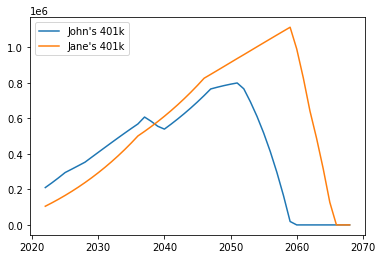

In [11]:
import matplotlib.pyplot as plt

year_df = pd.DataFrame(index = simulation.simulated_years)
year_df["John's 401k"] = john.legacy_retirement_accounts[0].stat_balance_history
year_df["Jane's 401k"] = jane.legacy_retirement_accounts[0].stat_balance_history

year_df.plot(subplots=False, legend=True)
plt.legend(loc='best')
plt.show()